<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection for a Digital Camera

## Introduction
This project implements a system to identify one or more faces within an image, developed from the research of source training images for features extraction to the creation of a model capable of returning the bounding boxes for each detected face in an input image.

The main point for a face detection algorithm is the conversion of the images into a set of features usable by a machine learning model. For this purpose, a feature description technique called Histogram of Oriented Gradients (HOG) has been employed. 

The HOG is a feature extraction technique used in image analysis for object detection. It is based on the concept that the appearance and shape of an object can be described by the distribution of local gradient intensities or gradient orientations in the image. The image is divided into smaller regions called cells and for each gradient direction within each cell the histogram of gradient is computed. These histograms are then normalized and concatenated to form the HOG features vector of the image, which can be used as input for classification or object detection algorithms.



## Elaboration Process
The whole process is divided into the following phases:
* **Dataset Management:** The preliminary phase involves importing the datasets, dividing them into positive classes containing faces and negative classes containing other elements. Specific operations will be performed during the import for some datasets, such as cropping faces to isolate only their features.
* **Image Preprocessing:** To prepare the training images, they will be converted to grayscale and uniformly resized. Additionally, for non-face images, further patches will be cropped to refine the variety of the negative class.
* **Features Extraction:** The training images will be converted into HOG features as previously explained.
* **Model Selection:** Several models will be explored by optimizing training hyperparameters as much as possible.
* **Sliding Windows:** Using the best trained model, the sliding windows technique will be used on the test image, by performing iterative classification for different portions of the image, in order to obtain all areas where faces are present.
* **Non-Maximum Suppression (NMS):** The raw list of all face bounding boxes will be refined by excluding images with suboptimal scores or those that excessively protrude from the image borders. Aboveall, the NMS technique will be used to select the most representative bounding boxes among those located and overlapping on the same faces.
* **Detection Testing**: Finally, the entire process will be encapsulated to test the detection algorithm on various images.

Further details will be provided for each step along the process.

## Sources

#### Detection Algorithm 
https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f <br>
https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/ <br>
https://builtin.com/machine-learning/non-maximum-suppression <br>

#### Python Code Examples
https://thepythoncode.com/article/hog-feature-extraction-in-python <br>
https://github.com/tanmay1908/face-detection-hog/blob/main/HOG_ver1.py <br>

## Datasets
Faces Images: <br>
8 - LFW People: https://www.kaggle.com/datasets/atulanandjha/lfwpeople <br>
1 - Face Detection: https://www.kaggle.com/datasets/trainingdatapro/face-detection-photos-and-labels <br>
9 - Olivetti Faces: https://github.com/lloydmeta/Olivetti-PNG <br>

Other Images: <br>
7 - Landscape Pictures: https://www.kaggle.com/datasets/arnaud58/landscape-pictures <br>
10 - House Rooms and Streets: https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset <br>
<br>

<font color='gray'>
DISCARDED: <br>
2 - Bounding Box at Face Sides: https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection <br>
6 - Gender Detection & Classification - Face Images: https://www.kaggle.com/datasets/trainingdatapro/gender-detection-and-classification-image-dataset <br>
3 - Celebrity Face Images: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset <br>
4 - Non-Face and Face Images: https://www.kaggle.com/datasets/sagarkarar/nonface-and-face-dataset <br>
5 - Natural Images: https://www.kaggle.com/datasets/prasunroy/natural-images <br>
</font>

## Output Settings

In [1]:
# To print more than one results in the same notebook cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

## Libraries

In [2]:
# Data
import pandas as pd
import numpy as np

# Utility
import os
import shutil
import sys
import math
import random
import scipy
import json
import xml.etree.ElementTree as ET
from time import time
from sklearn.utils import shuffle

# Plot
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

# Image
import cv2
from PIL import Image
from skimage import io, exposure
from skimage.feature import hog

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Modeling
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report

C:\Data\Tool\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Constants

In [3]:
# Random seeds for reproducibility
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Result value set in case of division by zero
ZERO_DIVISION = 0

# Number of parallel jobs (-1: maximum parallelism)
N_JOBS = -1

## Global Variables

In [4]:
# Process settings
perform_datasets_preprocessing = False # set to True only the first time to load the datasets in preprocessing folder
perform_images_preprocessing = False   # set to True only the first time to preprocess the images and load them in training folder
perform_hyperparameters_search = False # set to True to perform hyperparameters search by Grid and Random searches
load_trained_models = True             # set to False to train the models using hardcoded best hyperparameters, otherwise the already trained models are used

# Folders paths
PREPROCESSING_DATA_FOLDER = "Preprocessing_Data/"
TRAINING_DATA_FOLDER = "Training_Data/"
TEST_DATA_FOLDER = "Test_Data/"
FACES_IMAGES_FOLDER = "Faces/"
OTHER_IMAGES_FOLDER = "Other/"
SOURCE_IMAGES_FOLDER = "Original/"
GRAY_IMAGES_FOLDER = "Gray/"
RESIZED_IMAGES_FOLDER = "Resized/"
MODELS_FOLDER = "Models/"

# Allowed image file types
IMAGE_EXTENSIONS = (".jpg", ".jpeg")

# Target labels
LABEL_FACE = 1
LABEL_NON_FACE = 0

# Images sizes setting (if different from None, these sizes are forcedly set for images resizing)
HEIGHT_TRAINING_FIXED = None
WIDTH_TRAINING_FIXED = None

# Model paramaters
CROSS_VALIDATION_FOLDS = 5 # number of cross-validation folds for hyperparameters search
TEST_SIZE_RATIO = 0.3      # ratio for test data for train-test split

# Tables used to gather and compare the metrics for different models
metrics_index = ["Model", "Precision", "Recall", "Accuracy", "F1", "Log Loss"]
df_metrics_train = pd.DataFrame(columns = metrics_index)
df_metrics_test = pd.DataFrame(columns = metrics_index)

## Functions

#### Utilities

In [5]:
 def prediction(model, X_train, X_test):
    
    """ Evaluate and return the predicted values and related probabilities for target for train and test sets """
    
    # Train
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)

    # Test
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)

    return (y_pred_train, y_proba_train, y_pred_test, y_proba_test)


def show_classification_report(y, y_pred, title = None):
    if title != None:
        print(f"\n# {title} - Metrics #")
    print(classification_report(y, y_pred))


def plot_confusion_matrix(y_true, y_pred, y_proba, display_metrics = False, labels = ["Negative", "Positive"], title = None):
    """
    Plot confusion matrix using real and predicted target values from a classification model.
    Optionally display the related precision, recall and accuracy metrics.
    """
        
    cm = confusion_matrix(y_true, y_pred)
    #    0   1
    # 0 TN  FP
    # 1 FN  TP
    
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted " + labels[0], "Predicted " + labels[1]])
    
    sns.heatmap(df_cm, annot = True, fmt = "g") # fmt = "g" -> no scientific notation
    
    if title != None:
        plt.title(title + " - Confusion Matrix")
    
    if display_metrics:
        precision, recall, accuracy, _, _ = model_metrics(y_true, y_pred, y_proba)       
        plt.text(0, -0.2, f"Precision: {precision:.3f}") # TP/(TP + FP)
        plt.text(1, -0.2, f"Recall: {recall:.3f}")       # TP/(TP + FN)     
        plt.text(1.9, -0.2, f"Accuracy: {accuracy:.3f}") # (TP + TN)/(TP + FP + TN + FN)
        
    plt.show()
    
        
def model_metrics(y_true, y_pred, y_proba):
    """
    Receive real and predicted target values from a classification model and
    return the related precision, recall, accuracy, F1 score, and log loss metrics.
    """
       
    cm = confusion_matrix(y_true, y_pred)
    
    precision = precision_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    recall = recall_score(y_true, y_pred, zero_division = ZERO_DIVISION)       
    accuracy = (cm[0, 0] + cm[1,1])/np.sum(cm)  
    f1 = f1_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    log_loss_value = log_loss(y_true, y_proba)
    
    return [precision, recall, accuracy, f1, log_loss_value]


def store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test):
    
    """ Store train and test metrics in global dataframes variables """

    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Retrieve metrics lists
    metrics_model_train = model_metrics(y_train, y_pred_train, y_proba_train)
    metrics_model_test = model_metrics(y_test, y_pred_test, y_proba_test)

    # Prepend model name to lists
    metrics_model_train.insert(0, model_name)
    metrics_model_test.insert(0, model_name)

    # Create new dataframe row and append it to global metrics dataframes
    new_row = pd.DataFrame([metrics_model_train], columns = df_metrics_train.columns)
    df_metrics_train = pd.concat([df_metrics_train, new_row], ignore_index = True)      
    new_row = pd.DataFrame([metrics_model_test], columns = df_metrics_test.columns)
    df_metrics_test = pd.concat([df_metrics_test, new_row], ignore_index = True)

#### Logistic Regressor

In [6]:
def generate_logistic_regressor(X, y,
                                
                                # Train-Test split ratio
                                test_size = 0.3,
                                
                                # LogisticRegression parameters
                                class_weight = None,
                                regularization = 'l2',
                                max_iter = 100,
                                               
                                # Preprocessing parameters
                                scaler = 'Standard',
                                sampler = None,
                                sampling_strategy = None,
                                               
                                # Random seed for reproducibility
                                random_state = None,
                                               
                                # Model name to allow metrics storage
                                model_name = '', 
                                               
                                # Metrics display option
                                show_metrics = False,
                                show_confusion_matrix = False):
    
    """
    Create a logistic regressor model receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the pipeline including trained model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test
    
    # Pipeline steps settings
    pipe_steps = []

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Scaling
    if scaler == 'Standard':   
        # Standardization
        pipe_steps.append(('scaler', StandardScaler()))    
    elif scaler == 'MinMax':      
        # Normalization
        pipe_steps.append(('scaler', MinMaxScaler()))
    else:    
        # No data scaling applied
        pass
    
    # Undersampling
    if sampler == "RandomUnderSampler" and sampling_strategy != '':
        rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = random_state)
        pipe_steps.append(('undersampler', rus))
    
    # Oversampling
    if sampler == "RandomOverSampler" and sampling_strategy != '':
        ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = random_state)
        pipe_steps.append(('oversampler', ros))
        
    # Regularization
    if regularization != None:   
        penalty = regularization
        if regularization == "l1":
            solver = 'liblinear'
            np.random.seed(random_state) # to force liblinear to exploit random_state seed
        else:
            solver = 'lbfgs' # default
    else:
        solver = 'lbfgs' # default

    # Logistic regression settings
    lr = LogisticRegression(class_weight = class_weight, penalty = penalty, solver = solver, max_iter = max_iter)
    pipe_steps.append(('logistic_regression', lr))
    
    # Pipeline creation and training
    pipeline = Pipeline(pipe_steps)
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(pipeline, X_train, X_test)
        
    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
       
    return pipeline

#### Support Vector Machine

In [7]:
def generate_SVM_classifier(X, y,
                            
                            # Train-Test split ratio
                            test_size = 0.3,

                            # SVM parameters
                            kernel = 'rbf',
                            weight = None,
                            C = 1.0, # inverse proportional, squared L2 regularization
                            degree = 3,
                            gamma = 'scale',
                            
                            # Preprocessing parameters
                            scaler = 'Standard',

                            # Random seed for reproducibility
                            random_state = None,

                            # Model name to allow metrics storage
                            model_name = '',

                            # Metrics display option
                            show_metrics = False,
                            show_confusion_matrix = False):

    """
    Create a SVM classifier receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the pipeline including trained model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test
    
    # Pipeline steps settings
    pipe_steps = []

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Scaling
    if scaler == 'Standard':   
        # Standardization
        pipe_steps.append(('scaler', StandardScaler()))    
    elif scaler == 'MinMax':      
        # Normalization
        pipe_steps.append(('scaler', MinMaxScaler()))
    else:    
        # No data scaling applied
        pass
    
    # Class weight
    if weight != None:
        if weight == 'balanced':
            class_weight = weight
        elif weight.isdigit():
            # Dictionary assigning the weight to minority class supposing binary target
            class_weight = {pd.Series(y).value_counts().idxmin() : weight}
    else:
        class_weight = None
        
    # SVC settings
    svc = SVC(kernel = kernel, class_weight = class_weight, C = C, degree = degree, gamma = gamma, probability = True)
    pipe_steps.append(('svc', svc))
    
    # Pipeline creation and training
    pipeline = Pipeline(pipe_steps)
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(pipeline, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return pipeline

#### Neural Network

In [8]:
def generate_MLP_classifier(X, y,
                            
                            # Train-Test split ratio
                            test_size = 0.3,
                            
                            # MLP parameters
                            hidden_layer_sizes = (100,),
                            activation = 'relu',
                            learning_rate = 'constant',
                            solver = 'adam',
                            max_iter = 200,
                            
                            # Preprocessing parameters
                            scaler = 'MinMax',

                            # Random seed for reproducibility
                            random_state = None,

                            # Model name to allow metrics storage
                            model_name = '',

                            # Metrics display option
                            show_metrics = False,
                            show_confusion_matrix = False):

    """
    Create a Multi Layer Perceptron classifier receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the pipeline including trained model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test
    
    # Pipeline steps settings
    pipe_steps = []

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Scaling
    if scaler == 'Standard':   
        # Standardization
        pipe_steps.append(('scaler', StandardScaler()))    
    elif scaler == 'MinMax':      
        # Normalization
        pipe_steps.append(('scaler', MinMaxScaler()))
    else:    
        # No data scaling applied
        pass
        
    # Model training
    mlp = MLPClassifier(activation = activation, hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, solver = solver, max_iter = max_iter, random_state = random_state)
    pipe_steps.append(('mlp', mlp))
       
    # Pipeline creation and training
    pipeline = Pipeline(pipe_steps)
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(mlp, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return pipeline

## 1 - Datasets Preprocessing

All datasets have been cleaned beforehand using a freeware tool to find duplicate images.

#### Cleaning of Preprocessing Data

In [9]:
if perform_datasets_preprocessing:
    
    # Remove all files recursively into nested folders
    for root, dirs, files in os.walk(PREPROCESSING_DATA_FOLDER):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

#### Dataset 1 - Faces

For each image, the portion delimited by the bounding box is cropped and then it is rotated to be vertically aligned. Finally it is saved in the training folder.

In [10]:
if perform_datasets_preprocessing:
    
    # Dataset 1 paths and names
    DATASET_1_FOLDER = "Datasets/1/"
    DATASET_1_XML_FILE = "annotations.xml"
    DATASET_1_IMAGE_PREFIX = "D1_"

    # Parse the XML file
    xml_tree = ET.parse(os.path.join(DATASET_1_FOLDER, DATASET_1_XML_FILE))
    root = xml_tree.getroot()

    # Iterate over each image
    for image in root.findall('image'):

        # Read image name
        image_name = image.get('name')

        # Load the image
        image_path = os.path.join(DATASET_1_FOLDER, image_name)
        with Image.open(image_path) as image_file:

            # Extract box details
            box = image.find('box')
            box_xtl = int(float(box.get('xtl')))         # top left x coordinate
            box_ytl = int(float(box.get('ytl')))         # top left y coordinate
            box_xbr = int(float(box.get('xbr')))         # bottom right x coordinate
            box_ybr = int(float(box.get('ybr')))         # bottom right y coordinate
            box_rotation = float(box.get('rotation', 0)) # rotation angle, 0 if not provided

            # Calculate the bounding box center
            box_center_x = (box_xtl + box_xbr)/2
            box_center_y = (box_ytl + box_ybr)/2

            # Rotate the original image according to box rotation
            rotated_image = image_file.rotate(box_rotation, center = (box_center_x, box_center_y), expand = True)

            # Crop the rotated image based on the bounding box coordinates
            cropped_image = rotated_image.crop((box_xtl, box_ytl, box_xbr, box_ybr))

            # Construct the path to training folder and output image name
            _, image_name_output = image_name.split('/')
            cropped_image_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER, DATASET_1_IMAGE_PREFIX + image_name_output))

            # Save the image
            cropped_image.save(cropped_image_path)

#### Dataset 8 - Faces

The images are cropped by a fixed ratio to include as much of the face as possible.

In [11]:
def crop_image(image_path, crop_ratio):
    
    """ Crop an image by a percentage and return it """
    
    # Open the image
    with Image.open(image_path) as image:
        
        # Get the original width and height
        width, height = image.size
        
        # Calculate the cropping dimensions
        crop_width = int(width * crop_ratio)
        crop_height = int(height * crop_ratio)
        
        # Calculate the crop box coordinates
        left = (width - crop_width) // 2
        top = (height - crop_height) // 2
        right = (width + crop_width) // 2
        bottom = (height + crop_height) // 2
        
        # Crop the image
        cropped_image = image.crop((left, top, right, bottom))
        
        return cropped_image

In [12]:
# Percentage of image to crop
CROP_RATIO = 0.4

if perform_datasets_preprocessing:
    
    # Dataset 8 paths and names
    DATASET_8_FOLDER = "Datasets/8/"
    DATASET_8_IMAGES_FOLDER = DATASET_8_FOLDER
    DATASET_8_IMAGE_PREFIX = "D8_"
    
    # List all images in the folder
    file_names = [file_name for file_name in os.listdir(DATASET_8_IMAGES_FOLDER) if file_name.endswith(IMAGE_EXTENSIONS)]
    
    # Copy all images
    for file_name in file_names:
        
        # Source path
        source_path = os.path.abspath(os.path.join(DATASET_8_IMAGES_FOLDER, file_name))
        
        # Apply crop to the image
        cropped_image = crop_image(source_path, CROP_RATIO)
        
        # Destination path
        destination_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER, DATASET_8_IMAGE_PREFIX + file_name))

        # Save cropped image
        cropped_image.save(destination_path)

#### Dataset 9 - Faces

In [13]:
if perform_datasets_preprocessing:
    
    # Dataset 9 paths and names
    DATASET_9_FOLDER = "Datasets/9/"
    DATASET_9_IMAGES_FOLDER = DATASET_9_FOLDER
    DATASET_9_IMAGE_PREFIX = "D9_"
    
    # List all images in the folder
    file_names = os.listdir(DATASET_9_IMAGES_FOLDER)
    
    # Copy all images
    for file_name in file_names:
        
        # Source path
        source_path = os.path.abspath(os.path.join(DATASET_9_IMAGES_FOLDER, file_name))
        
        # Destination path
        destination_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER, DATASET_9_IMAGE_PREFIX + file_name))

        # Copy image
        shutil.copyfile(source_path, destination_path)

#### Dataset 2 - Faces <font color = 'yellow'> [NOT USED] </font>

For each image, the portion delimited by the bounding box is cropped, and then it is saved in the training folder. If the bounding box is not square, it is cropped to prevent excessive distortion during subsequent resizing.

<font color = 'yellow'> NOTE: This dataset is not currently used for faces, as there are many faces in non-frontal or incomplete positions which were degrading model performance. </font>

In [14]:
def crop_to_square(box_x0, box_y0, box_x1, box_y1):
    
    """ Crop a bounding box to a square by trimming equally on both sides of the longer dimension and return the updated coordinates """
    
    # Calculate the width and height of the bounding box
    width = box_x1 - box_x0
    height = box_y1 - box_y0
    
    # Determine which side is shorter
    if width < height:
        
        # Calculate how much to trim from each side of the longer dimension
        trim_amount = (height - width) // 2
        
        # Adjust the coordinates to crop equally on both sides
        new_x0 = box_x0
        new_y0 = box_y0 + trim_amount
        new_x1 = box_x1
        new_y1 = box_y1 - trim_amount
        
    else:
        
        # Calculate how much to trim from each side of the longer dimension
        trim_amount = (width - height) // 2
        
        # Adjust the coordinates to crop equally on both sides
        new_x0 = box_x0 + trim_amount
        new_y0 = box_y0
        new_x1 = box_x1 - trim_amount
        new_y1 = box_y1
    
    return new_x0, new_y0, new_x1, new_y1

In [15]:
# Dsiable dataset utilization
DATASET_DISABLED = 0

if perform_datasets_preprocessing and DATASET_DISABLED:
    
    # Dataset 2 paths and names
    DATASET_2_FOLDER = "Datasets/2/"
    DATASET_2_IMAGES_FOLDER = DATASET_2_FOLDER + "images"
    DATASET_2_CSV_FILE = "faces.csv"
    DATASET_2_IMAGE_PREFIX = "D2_"
    
    # Load CSV file into a dataframe
    df_faces = pd.read_csv(os.path.join(DATASET_2_FOLDER, DATASET_2_CSV_FILE))
    
    # Iterate over each row in the DataFrame
    for index, row in df_faces.iterrows():
        
        # Read image info
        image_name = row['image_name']
        image_width = int(row['width'])
        image_height = int(row['height'])
        box_x0 = int(row['x0'])
        box_y0 = int(row['y0'])
        box_x1 = int(row['x1'])
        box_y1 = int(row['y1'])
        
        # Load the image
        image_path = os.path.join(DATASET_2_IMAGES_FOLDER, image_name)     
        if os.path.exists(image_path): # check necessary due to the cleaning of duplicated images from folder, but not from csv file
            with Image.open(image_path) as img:
                
                # Squared bounding box
                box_x0, box_y0, box_x1, box_y1 = crop_to_square(box_x0, box_y0, box_x1, box_y1)

                # Crop the image based on the bounding box coordinates
                cropped_img = img.crop((box_x0, box_y0, box_x1, box_y1))

                # Construct the path to training folder and output image name
                cropped_image_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER, DATASET_2_IMAGE_PREFIX + image_name))

                # Save the image
                cropped_img.save(cropped_image_path)

#### Dataset 2 - Other

For each image, portions on all sides of the bounding box are selected to capture body elements other than the face, often included among false positives detection.

NOTE: All images with more than one face have been manually removed because duplicate removal via the CSV file check is not exhaustive and many faces were found in the new side bounding boxes.

In [16]:
def side_patch_outside_box(image, side, box_x0, box_y0, box_x1, box_y1):
    """
    Generate a bounding box with the same dimensions as the input box but positioned differently based on the specified side.
    Return the shifted bounding box along with a validity flag indicating if the shifted box remains within the image boundaries.
    """
    
    # Image sizes
    image_height = image.height
    image_width = image.width
    
    # Calculate the width and height of the input bounding box
    box_width = box_x1 - box_x0
    box_height = box_y1 - box_y0
    
    # Determine the new position based on the specified side
    if side == 'top':
        new_x0 = box_x0
        new_y0 = box_y0 - box_height
        new_x1 = box_x1
        new_y1 = box_y1 - box_height
    elif side == 'bottom':
        new_x0 = box_x0
        new_y0 = box_y0 + box_height
        new_x1 = box_x1
        new_y1 = box_y1 + box_height
    elif side == 'right':
        new_x0 = box_x0 + box_width
        new_y0 = box_y0
        new_x1 = box_x1 + box_width
        new_y1 = box_y1
    elif side == 'left':
        new_x0 = box_x0 - box_width
        new_y0 = box_y0
        new_x1 = box_x1 - box_width
        new_y1 = box_y1
    elif side == 'box':
        new_x0 = box_x0
        new_y0 = box_y0
        new_x1 = box_x1
        new_y1 = box_y1
    else:
        raise ValueError("Invalid value for 'side'")
        
    # Check if bounding box is inside the image
    if new_x0 < 0 or new_y0 < 0 or new_x1 > image_width or new_y1 > image_height:
        patch_validity = False
    else:
        patch_validity = True

    return patch_validity, new_x0, new_y0, new_x1, new_y1

In [17]:
if perform_datasets_preprocessing:
    
    # Dataset 2 paths and names
    DATASET_2_FOLDER = "Datasets/2/"
    DATASET_2_IMAGES_FOLDER = DATASET_2_FOLDER + "images"
    DATASET_2_CSV_FILE = "faces.csv"
    DATASET_2_IMAGE_PREFIX = "D2_"
    
    # Load CSV file into a dataframe
    df_faces = pd.read_csv(os.path.join(DATASET_2_FOLDER, DATASET_2_CSV_FILE))
    
    # Found all duplicated image names, therefore images having more than one face
    duplicate_image_names = df_faces[df_faces.duplicated(subset = ['image_name'], keep = False)]['image_name'].unique()

    # Remove all image with more than one face
    df_no_duplicates = df_faces[~df_faces['image_name'].isin(duplicate_image_names)]
    
    # Iterate over each row in the DataFrame
    for index, row in df_no_duplicates.iterrows():
        
        # Read image info
        image_name = row['image_name']
        image_width = int(row['width'])
        image_height = int(row['height'])
        box_x0 = int(row['x0'])
        box_y0 = int(row['y0'])
        box_x1 = int(row['x1'])
        box_y1 = int(row['y1'])
        
        # Load the image
        image_path = os.path.join(DATASET_2_IMAGES_FOLDER, image_name)     
        if os.path.exists(image_path): # check necessary due to the cleaning of duplicated images from folder, but not from csv file
            with Image.open(image_path) as image_file:
                
                # Select cyclically all side boxes
                sides = ['top', 'bottom', 'right', 'left']
                
                for side in sides:
                
                    # Select the portion for the selected side of the bounding box
                    patch_validity, side_x0, side_y0, side_x1, side_y1 = side_patch_outside_box(img, side, box_x0, box_y0, box_x1, box_y1)
                        
                    # If the patch is inside the image
                    if patch_validity:

                        # Crop the image based on the bounding box coordinates
                        cropped_image = image_file.crop((side_x0, side_y0, side_x1, side_y1))
                        
                        # Append side to file name
                        name, extension = image_name.split('.')
                        image_name_with_side = name + '_' + side + '.' + extension
                        
                        # Construct the path to training folder and output image name
                        cropped_image_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, OTHER_IMAGES_FOLDER, DATASET_2_IMAGE_PREFIX + image_name_with_side))

                        # Save the image
                        cropped_image.save(cropped_image_path)

#### Dataset 7 - Other

In [18]:
if perform_datasets_preprocessing:
    
    # Dataset 7 paths and names
    DATASET_7_FOLDER = "Datasets/7/"
    DATASET_7_IMAGES_FOLDER = DATASET_7_FOLDER
    DATASET_7_IMAGE_PREFIX = "D7_"
    
    # List all images in the folder
    file_names = os.listdir(DATASET_7_IMAGES_FOLDER)
    
    # Copy all images
    for file_name in file_names:
        
        # Source path
        source_path = os.path.abspath(os.path.join(DATASET_7_IMAGES_FOLDER, file_name))
        
        # Destination path
        destination_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, OTHER_IMAGES_FOLDER, DATASET_7_IMAGE_PREFIX + file_name))

        # Copy image
        shutil.copyfile(source_path, destination_path)

#### Dataset 10 - Other

In [19]:
if perform_datasets_preprocessing:
    
    # Dataset 10 paths and names
    DATASET_10_FOLDER = "Datasets/10/"
    DATASET_10_IMAGES_FOLDER = DATASET_10_FOLDER
    DATASET_10_IMAGE_PREFIX = "D10_"
    
    # List all images in the folder
    file_names = os.listdir(DATASET_10_IMAGES_FOLDER)
    
    # Copy all images
    for file_name in file_names:
        
        # Source path
        source_path = os.path.abspath(os.path.join(DATASET_10_IMAGES_FOLDER, file_name))
        
        # Destination path
        destination_path = os.path.abspath(os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, OTHER_IMAGES_FOLDER, DATASET_10_IMAGE_PREFIX + file_name))

        # Copy image
        shutil.copyfile(source_path, destination_path)

## 2 - Images Preprocessing

#### Cleaning of Preprocessed Gray and Resized Images

In [20]:
if perform_images_preprocessing:
    
    # Remove all files recursively into nested folders
    for root, dirs, files in os.walk(os.path.join(PREPROCESSING_DATA_FOLDER, GRAY_IMAGES_FOLDER)):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
                                     
    # Remove all files recursively into nested folders
    for root, dirs, files in os.walk(os.path.join(PREPROCESSING_DATA_FOLDER, RESIZED_IMAGES_FOLDER)):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

#### Cleaning of Training Data

In [21]:
if perform_images_preprocessing:
    
    # Remove all files recursively into nested folders
    for root, dirs, files in os.walk(TRAINING_DATA_FOLDER):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

#### Gray Scale Conversion

Converting the image to grayscale and increasing the contrast before computing the HOG features, it helps to simplify and focus the analysis on relevant details for shapes and contours recognition, making the process more efficient and generalizable.

In [22]:
def read_images(folder_path = "", allowed_file_types = ""):
    
    """ Read images from folder and return the images and file names lists """
    
    images_list = []

    # List images files
    file_names = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(allowed_file_types)]

    # Load images
    for file_name in file_names:

        # Image path
        image_path = os.path.join(folder_path, file_name)
        
        # Read image
        image = cv2.imread(image_path)
        
        # Append image and file name
        images_list.append(image)
        
    return images_list, file_names

In [23]:
def convert_and_equalize_images_to_gray_scale(images_list = []):
    
    """ Convert input images to gray scale, increase the contrast and return the images list """

    images_gray = []
    
    # Convert all images to gray scale
    for image in images_list:
        
        # Gray scale conversion
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Increase contrast
        image_gray_equalized = cv2.equalizeHist(image_gray)

        # Append the image
        images_gray.append(image_gray_equalized)
    
    return images_gray

In [24]:
def write_images(images_list = [], file_names = [], folder_path = ""):
    
    """ Save images into specified folder """

    # Save images
    for image, file_name in zip(images_list, file_names):
        
        # Image file path
        image_path = os.path.join(folder_path, file_name)
        
        # Write image
        cv2.imwrite(image_path, image)

In [25]:
# Face images
if perform_images_preprocessing:
    
    # Read face image file names
    source_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    images, file_names = read_images(folder_path = source_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Convert images to gray scale
    gray_images = convert_and_equalize_images_to_gray_scale(images_list = images)
    
    # Save face images
    gray_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, GRAY_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    write_images(images_list = gray_images, file_names = file_names, folder_path = gray_images_path)

In [26]:
# Other images
if perform_images_preprocessing:
    
    # Read other image file names
    source_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, OTHER_IMAGES_FOLDER)
    images, file_names = read_images(folder_path = source_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Convert images to gray scale
    gray_images = convert_and_equalize_images_to_gray_scale(images_list = images)
    
    # Save other images
    gray_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, GRAY_IMAGES_FOLDER, OTHER_IMAGES_FOLDER)
    write_images(images_list = gray_images, file_names = file_names, folder_path = gray_images_path)

#### Resizing

For all images it is mandatory to have the same dimensions during the process of extracting HOG features and to train the model, as they require consistent and homogeneous input data. <br>
Since the images may vary considerably in sizes andresizing all images to the maximum size would be computationally expensive, it is chosen to resize all images to the average dimensions, rounding the values to a multiple of the cell size used for HOG extraction.

In [27]:
if perform_images_preprocessing:
    
    # Read face image file names
    source_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, SOURCE_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    images, _ = read_images(folder_path = source_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Collect all heights and widths only for face images
    heights, widths = [], []
    for image in images:
        height, width, _ = image.shape # 3rd return value represents color channels
        heights.append(height)
        widths.append(width)

    # Plot the histogram of heights
    plt.hist(heights, bins = 30)
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Histogram of Image Heights')
    plt.show()

    # Plot the histogram of widths
    plt.hist(widths, bins = 30)
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Histogram of Image Widths')
    plt.show()

In [28]:
if perform_images_preprocessing:
    
    # Mean dimensions
    height_mean = sum(heights)/len(heights)
    print(f"Mean height: {height_mean:.0f}")

    width_mean = sum(widths)/len(widths)
    print(f"Mean width: {width_mean:.0f}")
    
    # Resized dimensions to nearest multiple of HOG cell size
    height_resized = round(height_mean/CELL_SIZE)*CELL_SIZE
    width_resized = round(width_mean/CELL_SIZE)*CELL_SIZE
    
    # Set sizes settings for training and processing
    if HEIGHT_TRAINING_FIXED == None or WIDTH_TRAINING_FIXED == None:
        print("\nImages resized with rounded mean sizes values:")
        image_height_training = height_resized
        image_width_training = width_resized
    else:
        print("\nImages resized with forced sizes values:")
        image_height_training = HEIGHT_TRAINING_FIXED
        image_width_training = WIDTH_TRAINING_FIXED

    print(f"- Resized height: {image_height_training}")
    print(f"- Resized width: {image_width_training}")

#### Refinement of Non-Faces Other Images

For the images that don't represent faces, randomly cropped smaller portions are taken if they are larger than a specified minimum size. This is done to provide image elements possibly at the same scale as the faces, so potentially more significant.

In [29]:
def resize_images(images_list = [], width = 1, height = 1):
    
    """ Convert input images to gray scale and return the images list """

    images_resized = []
    
    # Resized all images
    for image in images_list:
        
        # Image resize
        image_resized = cv2.resize(image, (width, height))

        # Append the image
        images_resized.append(image_resized)
    
    return images_resized

In [30]:
def random_crop_images(images_list = [], patch_height = 32, patch_width = 32):  
    """
    Generate a random crop for input images with aspect ratio defined by patch sizes.
    Return the images list.
    """
    
    images_cropped = []
    
    # For all images
    for image in images_list:

        # Image sizes
        image_height = image.shape[0]
        image_width = image.shape[1]
        
        if (image_height <= patch_height) and (image_width <= patch_width):
        
            # Append the original image
            images_cropped.append(image)
            
        else:

            # Set patch sizes
            crop_random_height = min(image_height, patch_height)
            crop_random_width = min(image_width, patch_width)

            # Calculate random crop position and set box coordinates
            x1 = random.randint(0, image_width - crop_random_width)
            y1 = random.randint(0, image_height - crop_random_height)
            x2 = x1 + crop_random_width
            y2 = y1 + crop_random_height

            # Crop the image
            image_cropped = image[y1:y2, x1:x2]

            # Append the cropped image
            images_cropped.append(image_cropped)
    
    return images_cropped

In [31]:
if perform_images_preprocessing:
    
    # Patch scale to eventually tune patch size
    PATCH_SCALE_FACTOR = 1
    
    # Patch height
    PATCH_HEIGHT = round(image_height_training/PATCH_SCALE_FACTOR)
    
    # Patch width
    PATCH_WIDTH = round(image_width_training/PATCH_SCALE_FACTOR)   

In [32]:
# Face images
if perform_images_preprocessing:
    
    # Read gray face image file names
    gray_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, GRAY_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    gray_images, file_names = read_images(folder_path = gray_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Resize gray images
    resized_images = resize_images(images_list = gray_images, width = image_width_training, height = image_height_training)
    
    # Save resized face images
    resized_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, RESIZED_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    write_images(images_list = resized_images, file_names = file_names, folder_path = resized_images_path)

In [33]:
# Other images
if perform_images_preprocessing:
    
    # Read gray other image file names
    gray_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, GRAY_IMAGES_FOLDER, OTHER_IMAGES_FOLDER)
    gray_images, file_names = read_images(folder_path = gray_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Randomly crop gray images
    cropped_images = random_crop_images(images_list = gray_images, patch_height = PATCH_HEIGHT, patch_width = PATCH_WIDTH)
    
    # Resize gray images
    resized_images = resize_images(images_list = cropped_images, width = image_width_training, height = image_height_training)
    
    # Save resized other images
    resized_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, RESIZED_IMAGES_FOLDER, OTHER_IMAGES_FOLDER)
    write_images(images_list = resized_images, file_names = file_names, folder_path = resized_images_path)

#### Populate Training Folder

The final images used for training the positive class with faces and the negative class without faces are then copied into the training folders.

In [34]:
# Face images
if perform_images_preprocessing:
    
    # Read gray face image file names
    resized_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, RESIZED_IMAGES_FOLDER, FACES_IMAGES_FOLDER)
    resized_images, file_names = read_images(folder_path = resized_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Save training face images
    training_images_path = os.path.join(TRAINING_DATA_FOLDER, FACES_IMAGES_FOLDER)
    write_images(images_list = resized_images, file_names = file_names, folder_path = training_images_path)

In [35]:
# Other images
if perform_images_preprocessing:
    
    # Read gray other image file names
    resized_images_path = os.path.join(PREPROCESSING_DATA_FOLDER, RESIZED_IMAGES_FOLDER, OTHER_IMAGES_FOLDER)
    resized_images, file_names = read_images(folder_path = resized_images_path, allowed_file_types = IMAGE_EXTENSIONS)
    
    # Save training other images
    training_images_path = os.path.join(TRAINING_DATA_FOLDER, OTHER_IMAGES_FOLDER)
    write_images(images_list = resized_images, file_names = file_names, folder_path = training_images_path)

## 3 - Images Acquisition

In [36]:
def load_and_label_images(images_list = [], labels_list = [], folder_path = "", allowed_file_types = "", label = None, maximum_number_of_images = 100):
    
    """ Load images from a specified folder, assign labels and append them to the respective lists, which are then returned in a tuple """

    # List images files
    files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(allowed_file_types)]

    # Select randomly the specified number of images or all the images in folder if they are less
    selected_files = random.sample(files, min(maximum_number_of_images, len(files)))

    # Load images
    for file_name in selected_files:
        
        # Image path
        image_path = os.path.join(folder_path, file_name)

        # Read the image in gray scale mode
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Append image and label to the lists
        images_list.append(image)
        labels_list.append(label)
        
    return (images_list, labels_list)

For the training of the models have been used 13333 faces images and 32267 other images.

In [37]:
if not load_trained_models:

    # Define the maximum number of images to load randomly from each folder
    NUMBER_FACES_IMAGES_TO_LOAD = 50000
    NUMBER_OTHER_IMAGES_TO_LOAD = 50000
    
else:
    
    # Load only first image to read training sizes
    NUMBER_FACES_IMAGES_TO_LOAD = NUMBER_OTHER_IMAGES_TO_LOAD = 1 

# Initialize the lists of images and corresponding labels indicating whether each image contains a face or not
images = []
labels = []

# Images paths
FACES_FOLDER_PATH = TRAINING_DATA_FOLDER + FACES_IMAGES_FOLDER
OTHER_FOLDER_PATH = TRAINING_DATA_FOLDER + OTHER_IMAGES_FOLDER

# Faces images       
images, labels = load_and_label_images(folder_path = FACES_FOLDER_PATH,
                                       allowed_file_types = IMAGE_EXTENSIONS,
                                       label = LABEL_FACE,
                                       maximum_number_of_images = NUMBER_FACES_IMAGES_TO_LOAD)
face_images_number = len(images)
print(f"Loaded {face_images_number} face images")

# Other images       
images, labels = load_and_label_images(images_list = images,
                                       labels_list = labels,
                                       folder_path = OTHER_FOLDER_PATH,
                                       allowed_file_types = IMAGE_EXTENSIONS, 
                                       label = LABEL_NON_FACE,
                                       maximum_number_of_images = NUMBER_OTHER_IMAGES_TO_LOAD)
other_images_number = len(images) - face_images_number
print(f"Loaded {other_images_number} other images")

Loaded 1 face images
Loaded 1 other images


In [38]:
if not perform_images_preprocessing:
    
    # Set predeterminated training sizes
    image_height_training = images[0].shape[0]
    image_width_training = images[0].shape[1]
    
print(f"Training image height: {image_height_training}")
print(f"Training image width: {image_width_training}")

Training image height: 112
Training image width: 104


In [39]:
# Check first image
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

## 4 - HOG Extraction

In [40]:
# HOG settings
ORIENTATIONS_NUMBER = 9        # number of angular direction between 0 and 180 degrees
CELL_SIZE = 8                  # dimension in pixels
BLOCK_SIZE = 2                 # number of cells per block
BLOCK_NORMALIZATION = 'L2-Hys' # 2-step L2 normalization limiting maximum value to 0.2

#### Test HOG algorithm

In [41]:
# HOG parameters
orientations = ORIENTATIONS_NUMBER
pixels_per_cell = (CELL_SIZE, CELL_SIZE)
cells_per_block = (BLOCK_SIZE, BLOCK_SIZE)
block_norm = BLOCK_NORMALIZATION

# Features extraction of first image
features, image_hog = hog(images[0],
                          orientations = orientations,
                          pixels_per_cell = pixels_per_cell,
                          cells_per_block = cells_per_block,
                          visualize = True,
                          block_norm = block_norm)

In [42]:
# Show HOG image
plt.figure(figsize = (15, 10))
plt.imshow(image_hog)
plt.axis('off')
plt.show()

#### Features Extraction

In [43]:
def extract_equalized_hog_features(image = None, orientations = 9, cell_size = 8, block_size = 2, block_norm = 'L2-Hys'):
    
    """ Extracts HOG features from the given image and applies histogram equalization and return the features list """

    # HOG parameters
    orientations = orientations
    pixels_per_cell = (cell_size, cell_size)
    cells_per_block = (block_size, block_size)
    block_norm = block_norm

    # HOG features extraction
    feature = hog(image = image,
                  orientations = orientations,
                  pixels_per_cell = pixels_per_cell,
                  cells_per_block = cells_per_block,
                  visualize = False,
                  block_norm = block_norm)
    
    # Histogram equalization
    feature_equalized = exposure.equalize_hist(feature)
    
    return feature_equalized

In [44]:
# Extract the features for all images
features = []
for image in images:
    
    # HOG features extraction
    feature = extract_equalized_hog_features(image, orientations = ORIENTATIONS_NUMBER, cell_size = CELL_SIZE, block_size = BLOCK_SIZE, block_norm = BLOCK_NORMALIZATION)
    
    # Append the features
    features.append(feature)

#### Features and Target Selection

In [45]:
# Select all features converting the list to numpy array
X = np.vstack(features)

# Select the target converting the list to a 1D numpy array 
y = np.vstack(labels)
y = np.ravel(y)

In [46]:
# Check features size
X.shape

(2, 5616)

In [47]:
# Check target size
y.shape

(2,)

## 5 - Models Training

#### Model 0 - Hold-Out Validation - Baseline

As a first step, a baseline model is constructed using a simple logistic regression. This model is validated using a dataset split into training and test sets, maintaining class proportionality between them. The training set is used to train the model, while the test set is reserved to evaluate the model's performance on new data.

In [48]:
if not load_trained_models:
    
    # Generation of logistic regressor
    pipe_lr = generate_logistic_regressor(X, y,
                                         test_size = TEST_SIZE_RATIO,
                                         max_iter = 500,
                                         scaler = 'MinMax',
                                         random_state = RANDOM_SEED,
                                         model_name = "M0_LogisticRegressor",
                                         show_confusion_matrix = True)
    
    # Store model pipeline
    joblib.dump(pipe_lr, MODELS_FOLDER + "pipe_lr.pkl")
    
    # Store metrics
    df_metrics_train.to_csv(MODELS_FOLDER + 'metrics_train.csv')
    df_metrics_test.to_csv(MODELS_FOLDER + 'metrics_test.csv')
    
else:

    # Load model pipeline
    pipe_lr = joblib.load(MODELS_FOLDER + "pipe_lr.pkl")
    
    # Load metrics
    df_metrics_train = pd.read_csv(MODELS_FOLDER + 'metrics_train.csv', index_col = 0)
    df_metrics_test = pd.read_csv(MODELS_FOLDER + 'metrics_test.csv', index_col = 0)

#### Model 1 - Support Vector Machine

A Support Vector Classifier model is trained for its ability to manage high-dimensional data, as implied by the HOG features, and to effectively identify intricate patterns typical of facial images.

In [49]:
if perform_hyperparameters_search:

    # Generate a logarithmic distribution for hyperparameters range
    param_range_logarithmic = scipy.stats.loguniform(0.0001, 1000)

    # Hyperparameter table
    SVC_hyperparameters_table = [

        # First configuration
        {'kernel' : ['linear', 'sigmoid', 'rbf'],
        'C' : param_range_logarithmic,
        'gamma' : param_range_logarithmic},

        # Second configuration
        {'kernel' : ['poly'],
        'degree' : [2, 3, 4, 5],
        'C' : param_range_logarithmic,
        'gamma' : param_range_logarithmic},
    ]

    # Scoring metric
    scoring_metric = 'accuracy'   

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, stratify = y, random_state = RANDOM_SEED)

    # Normalization
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)

    # SVC instance
    svc = SVC(random_state = RANDOM_SEED)

    # Starting time
    tick = time()

    # Evaluate best combination
    SVC_randomized = RandomizedSearchCV(svc, param_distributions = SVC_hyperparameters_table, scoring = scoring_metric, refit = True, cv = CROSS_VALIDATION_FOLDS, random_state = RANDOM_SEED, n_jobs = N_JOBS)
    SVC_randomized.fit(X_train, y_train)

    # Show training time
    print(f"Training completed in {time() - tick:.2f} seconds")
    
    # Set hyperparameters
    SVC_kernel = SVC_randomized.best_params_['kernel']
    SVC_C = SVC_randomized.best_params_['C']
    SVC_gamma = SVC_randomized.best_params_['gamma']
    
    if SVC_kernel == 'poly':
        SVC_degree = SVC_randomized.best_params_['degree']
    else:
        SVC_degree = 3 # default
    
    # Best score and hyperparameters
    print(f"Best score: {SVC_randomized.best_score_:.3f}")
    print(f"Best hyperparameters: {SVC_randomized.best_params_}")

else:
    
    # Hardcoded hyperparameters
    SVC_kernel = 'poly'
    SVC_C = 5.651408634691192
    SVC_degree = 5
    SVC_gamma = 3.0161098106203506

_Noted best SVM combinations for reproducibility without launching the random search:_ <br>
Best score: 0.994 <br>
Best hyperparameters: {'C': 5.651408634691192, 'degree': 5, 'gamma': 3.0161098106203506, 'kernel': 'poly'}

In [50]:
if not load_trained_models:
    
    # Generation of SVC model
    pipe_svc = generate_SVM_classifier(X, y,
                              test_size = TEST_SIZE_RATIO,
                              kernel = SVC_kernel,
                              C = SVC_C,
                              degree = SVC_degree,
                              gamma = SVC_gamma,
                              scaler = 'MinMax',
                              random_state = RANDOM_SEED,
                              model_name = "M1_SupportVectorMachine",
                              show_confusion_matrix = True)

    # Store model pipeline
    joblib.dump(pipe_svc, MODELS_FOLDER + "pipe_svc.pkl")
    
    # Store metrics
    df_metrics_train.to_csv(MODELS_FOLDER + 'metrics_train.csv')
    df_metrics_test.to_csv(MODELS_FOLDER + 'metrics_test.csv')
    
else:

    # Load model pipeline
    pipe_svc = joblib.load(MODELS_FOLDER + "pipe_svc.pkl")
    
    # Load metrics
    df_metrics_train = pd.read_csv(MODELS_FOLDER + 'metrics_train.csv', index_col = 0)
    df_metrics_test = pd.read_csv(MODELS_FOLDER + 'metrics_test.csv', index_col = 0)

#### Model 2 - Neural Network

A Multi-Layer Perceptron is trained due to its effectiveness in face detection as they can automatically learn facial features representations from extensive training data, enabling accurate detection of faces from non-linear structures in complex and diverse contexts.

In [51]:
if perform_hyperparameters_search:

    # Hyperparameter table
    MLP_hyperparameters_table = {
        'hidden_layer_sizes': [(25, 25), (50, 50), (100, 100), (250, 250), (500, 500), (25, 25, 25), (50, 50, 50), (100, 100, 100), (250, 250, 250), (500, 500, 500)],
        'activation': ['relu', 'tanh', 'logistic'],
        'max_iter': [250, 500]  
    }

    # Scoring metric
    scoring_metric = 'accuracy'

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, stratify = y, random_state = RANDOM_SEED)

    # Normalization
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)

    # MLP instance
    mlp = MLPClassifier(random_state = RANDOM_SEED)

    # Starting time
    tick = time()

    # Evaluate best combination
    MLP_grid = GridSearchCV(mlp, param_grid = MLP_hyperparameters_table, scoring = scoring_metric, refit = True, cv = CROSS_VALIDATION_FOLDS, n_jobs = N_JOBS)
    MLP_grid.fit(X_train, y_train)

    # Show training time
    print(f"Training completed in {time() - tick:.2f} seconds")

    # Set hyperparameters
    MLP_hidden_layer_sizes = MLP_grid.best_params_['hidden_layer_sizes']
    MLP_activation = MLP_grid.best_params_['activation']
    MLP_max_iter = MLP_grid.best_params_['max_iter']
    
    # Best score and hyperparameters
    print(f"Best score: {MLP_grid.best_score_:.3f}")
    print(f"Best hyperparameters: {MLP_grid.best_params_}")

else:
    
    # Hardcoded hyperparameters
    MLP_hidden_layer_sizes = (250, 250, 250)
    MLP_activation = 'relu'
    MLP_max_iter = 250

_Noted best MLP combinations for reproducibility without launching the grid search:_ <br>
Best score: 0.996 <br>
Best hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (250, 250, 250), 'max_iter': 250}

In [52]:
if not load_trained_models:
    
    # Generation of MLP model
    pipe_mlp = generate_MLP_classifier(X, y,
                                  test_size = TEST_SIZE_RATIO,
                                  hidden_layer_sizes = MLP_hidden_layer_sizes,
                                  activation = MLP_activation,
                                  max_iter = MLP_max_iter,
                                  scaler = 'MinMax',
                                  random_state = RANDOM_SEED,
                                  model_name = "M2_MultiLayerPerceptron",
                                  show_confusion_matrix = True)

    # Store model pipeline
    joblib.dump(pipe_svc, MODELS_FOLDER + "pipe_mlp.pkl")
    
    # Store metrics
    df_metrics_train.to_csv(MODELS_FOLDER + 'metrics_train.csv')
    df_metrics_test.to_csv(MODELS_FOLDER + 'metrics_test.csv')
    
else:

    # Load model pipeline
    pipe_mlp = joblib.load(MODELS_FOLDER + "pipe_mlp.pkl")
    
    # Load metrics
    df_metrics_train = pd.read_csv(MODELS_FOLDER + 'metrics_train.csv', index_col = 0)
    df_metrics_test = pd.read_csv(MODELS_FOLDER + 'metrics_test.csv', index_col = 0)

#### Models Comparison and Selection

In [53]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 3)

Train Models - Metrics Comparison


Model  Precision  Recall  Accuracy   F1  Log Loss
0     M0_LogisticRegressor        1.0     1.0       1.0  1.0       0.0
1  M1_SupportVectorMachine        1.0     1.0       1.0  1.0       0.0
2  M2_MultiLayerPerceptron        1.0     1.0       1.0  1.0       0.0

In [54]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 3)

Train Models - Metrics Comparison


Model  Precision  Recall  Accuracy     F1  Log Loss
0     M0_LogisticRegressor      0.992   0.989     0.995  0.991     0.018
1  M1_SupportVectorMachine      0.996   0.991     0.996  0.994     0.010
2  M2_MultiLayerPerceptron      0.989   0.991     0.994  0.990     0.051

#### Best Model Selection

The model with the highest accuracy is chosen as the best model because it equally helps avoid false positives, where faces are detected incorrectly, and false negatives, where faces are not detected in a photo. The selected SVC model also exhibits a lower log loss compared to the other developed models.

In [55]:
# Best model selection
best_model = pipe_svc

## 6 - Detection Process Steps

#### Utility Functions

In [56]:
def convert_to_equalized_gray_scale(image = None, show = False):
    
    """ Convert the image to gray scale increasing the contrast """

    # Gray scale conversion
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Increase contrast
    image_gray_equalized = cv2.equalizeHist(image_gray)
    
    # Show image
    if show:
        plt.imshow(image_test_preprocessed, cmap = 'gray')
        plt.axis('off')
        plt.show()

    return image_gray_equalized

In [57]:
def resize_image(image = None, width = 1, height = 1):
    
    """ Resize the image based on input sizes """

    image_resized = cv2.resize(image, (width, height))

    return image_resized

In [58]:
def padder(image = None, padding = [0, 0], padding_color = 0):
    
    """ Pad the image differently for height and width but simmetrically on both direction """
    
    # Set the padding for current window
    pad_height = padding[0]
    pad_width = padding[1]

    image_padded = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode = 'constant', constant_values = padding_color)

    return image_padded

In [59]:
def flatten_feature(feature):
    
    """ Adapt extracted HOG feature for model prediction converting them to a 1D array """

    # Concatenate all features converting the list to 1D numpy array
    feature_stacked = np.vstack(feature)
    feature_flattened = feature_stacked.flatten()

    return feature_flattened

#### Detection Process Functions

In [60]:
def generate_sliding_windows(image, window_height, window_width, window_size_scale = 0.5, min_size_ratio = 0.1, window_shift_overlap_ratio = 0.5, padding_color = 0):
    """
    Generate windows of different sizes and position, based on scaled size ratio and overlap ratio specified.
    Return:
    - the list of coordinates, where each list element defines the upper-left and lower-right corners of window bounding box.
    - the reference padding values for each window.
    """    
    
    # Initialize windows a reference paddings lists
    windows = []
    reference_paddings = []
    
    # Initialize windows sizes
    windows_min_height_real = window_height_scaled = window_height
    windows_min_width_real = window_width_scaled = window_width
    
    # Convert the image to gray scale and increase the contrast
    image_preprocessed = convert_to_equalized_gray_scale(image)
    
    # Image sizes
    image_height = image_preprocessed.shape[0]
    image_width = image_preprocessed.shape[1]
    
    # Set minimum windows sizes
    windows_min_height = image_height*min_size_ratio
    windows_min_width = image_width*min_size_ratio
    
    # Generate the windows across the image
    while (window_height_scaled >= windows_min_height) and (window_width_scaled >= windows_min_width):
        
        # Update minimum sizes for display info
        windows_min_height_real = window_height_scaled
        windows_min_width_real = window_width_scaled
        
        # Image padding sizes equal to half window sizes
        pad_height = window_half_height = round(window_height_scaled/2)
        pad_width = window_half_width = round(window_width_scaled/2)      
        
        # Pad the image for current window size
        image_padded = padder(image_preprocessed, [pad_height, pad_width], padding_color)

        # Padded image sizes
        image_padded_height = image_padded.shape[0]
        image_padded_width = image_padded.shape[1]
        
        # Set window shift based on current window size and specified overlap ratio
        vertical_shift = round(window_height_scaled*(1 - window_shift_overlap_ratio))
        horizontal_shift = round(window_width_scaled*(1 - window_shift_overlap_ratio))
    
        # Generate all windows for current window size
        for y in range(0, image_padded_height - window_half_height, vertical_shift):
            for x in range(0, image_padded_width - window_half_width, horizontal_shift):

                # Calculate coordinates of bounding box
                upper_left_x = x
                upper_left_y = y
                lower_right_x = x + window_width_scaled 
                lower_right_y = y + window_height_scaled
                
                # Append the window and the related reference padding
                windows.append([upper_left_x, upper_left_y, lower_right_x, lower_right_y])
                reference_paddings.append([pad_height, pad_width])
                    
        # Windows size for current scale factor
        window_height_scaled = round(window_height_scaled*window_size_scale)
        window_width_scaled = round(window_width_scaled*window_size_scale)       
    
    print(f"Generated {len(windows)} windows:\n- maximum size: {window_width}x{window_width}\n- minimum size: {windows_min_width_real}x{windows_min_height_real}\n- scaling ratio: {window_size_scale}\n")
    
    return windows, reference_paddings

In [61]:
def sliding_windows_classifier(model = None, image = [], image_height_training = 1, image_width_training = 1,
                               windows = [], padding_color = 0, reference_paddings = [],
                               orientations_number = 9, cell_size = 8, block_size = 2, block_normalization = 'L2-Hys'):
    
    """
    Slide windows across the given image and use a classifier model to detect objects within the windows.
    Return the list of bounding boxes where a face has been detected along with their respective padding values and probability scores.
    """    

    # Initialize detected results lists
    detected_faces_bounding_boxes = []
    detected_faces_reference_paddings = []
    scores = []
    
    # Convert the image to gray scale and increase the contrast
    image_preprocessed = convert_to_equalized_gray_scale(image)
    
    # Slide windows across the image
    for window, padding in zip(windows, reference_paddings):

        # Windows coordinates
        x1, y1, x2, y2 = window
        
        # Pad the image for current window size
        image_padded = padder(image_preprocessed, padding, padding_color)

        # Extract the window from the image
        image_window = image_padded[y1:y2, x1:x2]      

        # Resize the window image as training size
        image_window_resized = resize_image(image_window, image_width_training, image_height_training)

        # HOG features extraction       
        image_feature = extract_equalized_hog_features(image_window_resized, orientations = orientations_number, cell_size = cell_size, block_size = block_size, block_norm = block_normalization)

        # Concatenate all features converting the list to 1D numpy array
        X_image = flatten_feature(image_feature)
        
        # Make prediction using the best classifier model
        prediction = model.predict([X_image])
        
        # Store probability score related to positive face class
        score = model.predict_proba([X_image.flatten()])
        score_face = score[:, 1]     

        # If the window is predicted to contain a face, add the bounding box, the related padding and score to the lists
        if prediction == LABEL_FACE: 
            detected_faces_bounding_boxes.append([x1, y1, x2, y2])
            detected_faces_reference_paddings.append(padding)
            scores.append(score_face)

    print(f"Detected {len(detected_faces_bounding_boxes)} faces during sliding windows classification")
    
    return detected_faces_bounding_boxes, detected_faces_reference_paddings, scores

In [62]:
def face_probability_selection(boxes = [], paddings = [], scores = [], probability_threshold = 0.9):   
    
    """
    Keep from the input boxes list only the faces over a specified probability value.
    Return remaing faces bounding boxed with their respective padding values and probability scores.
    """
    
    # Initialize faces info lists
    boxes_over_threshold = []
    paddings_over_threshold = []
    scores_over_threshold = []

    # Filter detected faces over threshold
    for i in range(len(boxes)):
        if scores[i] >= probability_threshold:
            boxes_over_threshold.append(boxes[i])
            paddings_over_threshold.append(paddings[i])
            scores_over_threshold.append(scores[i])

    print(f"Kept {len(boxes_over_threshold)} faces with a probability over {probability_threshold*100:.1f}%")
    
    return boxes_over_threshold, paddings_over_threshold, scores_over_threshold

In [63]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Return the IoU value and the size difference between the compared bounding boxes.    
    """
    
    # Bounding boxes coordinates
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    # Intersection top left coordinate
    x5 = max(x1, x3)
    y5 = max(y1, y3)
    
    # Intersection bottom right coordinate
    x6 = min(x2, x4)
    y6 = min(y2, y4)

    # Calculate intersection area
    if (x6 - x5) > 0 or (y6 - y5) > 0:
        intersection_area = (x6 - x5) * (y6 - y5)
    else:
        # No intersection
        intersection_area = 0

    # Calculate areas of individual boxes
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)

    # Calculate union area
    union_area = area1 + area2 - intersection_area

    # Calculate IoU
    iou = intersection_area/union_area
    
    # Calculate scale factor
    scale_factor = max(area1, area2)/min(area1, area2)

    return iou, scale_factor

In [64]:
def non_maximum_suppression(boxes, scores, paddings, overlap_threshold = 0.5):
    """
    Applies non-maximum suppression to the list of bounding boxes ordered in desceding score value.
    The overlap comparison is performed by scaling the boxes as they were of the same size, so not to penalize smaller boxes.
    Return not suppressed faces bounding boxed with their respective padding values and probability scores.
    """
    
    # Initialize boxes, paddings and scores lists
    selected_boxes = []
    selected_paddings = []
    selected_scores = []
    
    # If boxes and scores are provided
    if (boxes is not None) and (scores is not None):
        
        # Obtain indexes ordered in descending order related to best scores
        sorted_scores_indexes = sorted(range(len(scores)), key = lambda i: scores[i], reverse = True)
        
        # While scores indexes are available yet
        while sorted_scores_indexes:
            
            # Get the index of box with best score and remove it from the list
            best_index = sorted_scores_indexes.pop(0)
            
            # Append best box and related padding and score
            selected_boxes.append(boxes[best_index])
            selected_paddings.append(paddings[best_index])
            selected_scores.append(scores[best_index])
            
            # Initialize score list for indexes related to box not overlapping over the threshold
            sorted_scores_indexes_updated = []

            # Calcolate IoU for all remaing boxes
            for index in sorted_scores_indexes:
                
                # Evaluate IoU value between best box and current index box
                iou, scale_factor = calculate_iou(boxes[best_index], boxes[index])
                
                # Keep the indexes if IoU value under overlap threshold (scaled to compensate different window sizes)
                if iou < (overlap_threshold/scale_factor):
                    sorted_scores_indexes_updated.append(index)
            
            # Update the scores list
            sorted_scores_indexes = sorted_scores_indexes_updated
        
        # Select boxes and scores related to not removed faces
        for i in sorted_scores_indexes:
            selected_boxes.append(boxes[i])
            selected_paddings.append(paddings[i])
            selected_scores.append(scores[i])
            
    print(f"Kept {len(selected_boxes)} faces after non-maximum-suppression with overlap threshold of {overlap_threshold} ")

    return selected_boxes, selected_paddings, selected_scores

In [65]:
def filter_inside_faces(image, boxes, paddings, scores, inside_threshold):
    """
    Filter bounding boxes based on their percentage of intersection with the image.
    Return
    - the list of filtered bounding boxes, which are inside the image for at least the given threshold.
    - the respective padding values and probability scores.
    """
    
    # Initalize boxes and scores lists
    filtered_boxes = []
    filtered_paddings = []
    filtered_scores = []
    
    # Image sizes
    image_height, image_width = image.shape[:2]

    # For all box and correspoding score
    for box, padding, score in zip(boxes, paddings, scores):
        
        # Set box coordinates
        x_min, y_min, x_max, y_max = box

        # Calculate intersection area with image
        intersection_width = max(0, min(x_max, image_width) - max(x_min, 0))
        intersection_height = max(0, min(y_max, image_height) - max(y_min, 0))
        intersection_area = intersection_width*intersection_height

        # Calculate box area
        box_area = (x_max - x_min)*(y_max - y_min)

        # Calculate percentage of intersection
        percentage_intersection = intersection_area/box_area

        # Check if percentage exceeds threshold
        if percentage_intersection >= inside_threshold:
            filtered_boxes.append(box)
            filtered_paddings.append(padding)
            filtered_scores.append(score)
    
    print(f"Kept {len(filtered_boxes)} faces inside the image for at least {inside_threshold*100:.0f}% of their area")

    return filtered_boxes, filtered_paddings, filtered_scores

In [66]:
def visualize_detected_faces(image, boxes, paddings, scores = None):
    
    """ Visualize the bounding boxes on the given image with associated scores """
    
    # Create figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image, cmap = 'gray')
    
    # Add bounding boxes to the image
    for box, padding, score in zip(boxes, paddings, scores):
        
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        
        # Calculate width and height
        box_width = x_max - x_min
        box_height = y_max - y_min
        
        # Calculate position subtracting the padding sizes
        box_x = x_min - padding[1]
        box_y = y_min - padding[0]
        
        # Create a rectangle patch
        rectangle = patches.Rectangle(xy = (box_x, box_y), width = box_width, height = box_height, linewidth = 1, edgecolor = 'g', facecolor = 'none')
        
        # Add the patch to the ax
        ax.add_patch(rectangle)
        
        # Add score if available
        if scores is not None:
            
            # Convert score to float
            score = float(score)
            
            # Calculate fontsize and score position based on bounding box size
            fontsize = min(int(box_width/12.5), 30)
            ax.text(box_x + 0.05*box_width, box_y + 0.15*box_height, f"{score:.3f}", color = 'g', fontsize = fontsize)
        
    # Show image
    plt.axis('off')
    plt.show()

#### Reference Test Image

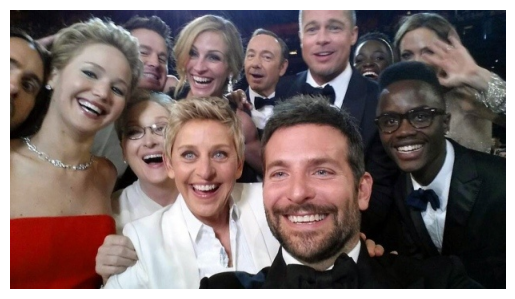

In [67]:
# Load test image
image_test = io.imread(os.path.join(TEST_DATA_FOLDER, "celebrity_selfie.jpg"))

# Check test image
plt.imshow(image_test)
plt.axis('off')
plt.show()

Below the face detection process is performed separately for each main step.

#### Sliding Windows

In [68]:
# Scale factor to reduce window size
WINDOW_SIZE_SCALE = 0.9 # [0, 1)

# Minimum window size in proportion to initial maximum windows size
MINIMUM_SIZE_RATIO = 0.1 # (0, 1)

# Windows is shifted in order to overlap the specified ratio of current window size
WINDOW_SHIFT_OVERLAP_RATIO = 0.9 # [0, 1)

# Black color value for image padding
PADDING_COLOR = 0

The windows are generated using the following approach:
* Starting from the maximum possible size, the image is scaled down (multiplied) by WINDOW_SIZE_SCALE at each iteration until the minimum size defined by MINIMUM_SIZE_RATIO is reached.
* For each generated window size, it is shifted so that the new position overlaps the previous one by a fraction equal to WINDOW_SHIFT_OVERLAP_RATIO.
* Each shift in position is performed horizontally and vertically to achieve a uniform grid coverage across the entire image, also considering the added padding.

In [69]:
# Test image sizes
image_test_height = image_test.shape[0]
image_test_width = image_test.shape[1]

# Square window sizes based on real image sizes
window_height = min(image_test_height, image_test_width)
window_width = min(image_test_height, image_test_width)

# Generate sliding windows
windows, reference_paddings = generate_sliding_windows(image = image_test,
                                                       window_height = window_height,
                                                       window_width = window_width,
                                                       window_size_scale = WINDOW_SIZE_SCALE,
                                                       min_size_ratio = MINIMUM_SIZE_RATIO,
                                                       window_shift_overlap_ratio = WINDOW_SHIFT_OVERLAP_RATIO,
                                                       padding_color = PADDING_COLOR)

Generated 34887 windows:
- maximum size: 349x349
- minimum size: 65x65
- scaling ratio: 0.9



#### Windows Classification

For each generated window, the corresponding image portion is converted to HOG features to assess whether that portion contains a face using the trained classifier model.

In [70]:
# Slide the windows and use trained model to detect faces and return related bounding boxes
boxes_faces, paddings_faces, scores_faces = sliding_windows_classifier(model = best_model,
                                                                       image_height_training = image_height_training, image_width_training = image_width_training,
                                                                       image = image_test,
                                                                       windows = windows, padding_color = PADDING_COLOR, reference_paddings = reference_paddings,
                                                                       orientations_number = ORIENTATIONS_NUMBER, cell_size = CELL_SIZE, block_size = BLOCK_SIZE, block_normalization = BLOCK_NORMALIZATION)

Detected 1090 faces during sliding windows classification


#### Filter Based on Probability Score

To clean up the faces detected with a probability not close to the maximum, bounding boxes below a certain threshold are eliminated.

In [71]:
# Set the minimum probability to consider valid the detected faces
FACE_PROBABILITY_THRESHOLD = 0.975

# Selection of faces over probability
boxes_over_threshold, paddings_over_threshold, scores_over_threshold = face_probability_selection(boxes = boxes_faces,
                                                                                                  paddings = paddings_faces,
                                                                                                  scores = scores_faces,
                                                                                                  probability_threshold = FACE_PROBABILITY_THRESHOLD)

Kept 291 faces with a probability over 97.5%


#### Non Maximum Suppression

Since sliding windows may contain the same face even for different window positions while moiving across a face, the non-maximum suppression algorithm is applied. <br>
After sorting the scores related to each face in descending order, the resulting highest score is retained and then the remaining bounding boxes are removed if the overlap portion exceeds the specified threshold. This process is repeated until all remaining bounding boxes meet this criterion.

In [72]:
# Maximum allowed overlap threshold to keep the bounding box
IOU_THRESHOLD = 0.1

# Non maximum suppression evaluation
boxes_nms, paddings_nms, scores_nms = non_maximum_suppression(boxes = boxes_over_threshold,
                                                              paddings = paddings_over_threshold,
                                                              scores = scores_over_threshold,
                                                              overlap_threshold = IOU_THRESHOLD)

Kept 9 faces after non-maximum-suppression with overlap threshold of 0.1 


#### Bounding Boxes Filter Based on Image Containment Ratio

To limit false positives in the padded areas of the image, bounding boxes that extend beyond a certain threshold from the image are arbitrarily removed.

In [73]:
# Minimum bounding box portion required to be inside the image area
INSIDE_BOX_THRESHOLD = 0.75

# Filter bounding boxes not exceeding image border beyond a given portion
boxes_inside, paddings_inside, scores_inside = filter_inside_faces(image = image_test,
                                                                  boxes = boxes_nms,
                                                                  paddings = paddings_nms,
                                                                  scores = scores_nms,
                                                                  inside_threshold = INSIDE_BOX_THRESHOLD)

Kept 9 faces inside the image for at least 75% of their area


## Show Detected Faces

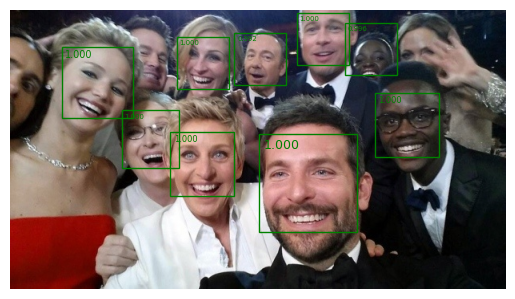

In [74]:
# Show detected faces on original image
visualize_detected_faces(image = image_test,
                         boxes = boxes_inside,
                         paddings = paddings_inside,
                         scores = scores_inside)

## 7 - Process Wrapping

After achieving a satisfactory result, the final settings for the window generation process and for the management of the bounding boxes are saved in a json files. Then the detection steps are consolidated into a single function.

NOTE: Training and HOG settings are provided for informational purposes only and are locked for manual changes. However, window and threshold settings can be manually adjusted before loading the json to assess how detection results are affected by these parameters.

In [75]:
# Salva le variabili globali in un file JSON
global_settings_path = os.path.join(MODELS_FOLDER, "global_settings.json")

with open(global_settings_path, 'w') as json_file:
    json.dump({
        'training_settings': {
            'IMAGE_HEIGHT_TRAINING': image_height_training,
            'IMAGE_WIDTH_TRAINING': image_width_training
        },
        'hog_settings': {
            'ORIENTATIONS_NUMBER': ORIENTATIONS_NUMBER,
            'CELL_SIZE': CELL_SIZE,
            'BLOCK_SIZE': BLOCK_SIZE,
            'BLOCK_NORMALIZATION': BLOCK_NORMALIZATION
        },
        'windows_settings': {
            'WINDOW_SIZE_SCALE': WINDOW_SIZE_SCALE,
            'MINIMUM_SIZE_RATIO': MINIMUM_SIZE_RATIO,
            'WINDOW_SHIFT_OVERLAP_RATIO': WINDOW_SHIFT_OVERLAP_RATIO,
            'PADDING_COLOR': PADDING_COLOR
        },
        'threshold_settings': {
            'FACE_PROBABILITY_THRESHOLD': FACE_PROBABILITY_THRESHOLD,
            'IOU_THRESHOLD': IOU_THRESHOLD,
            'INSIDE_BOX_THRESHOLD': INSIDE_BOX_THRESHOLD
        }
    }, json_file)

In [76]:
def faces_detector(image_path = "", model_path = "", json_path = ""):
    """
    DESCRIPTION HERE
    """
    
    # Starting time
    tick = time()
   
    # Read settings json
    with open(json_path, 'r') as json_file:
        data_settings = json.load(json_file)

    # Assegna variabili una ad una
    training_settings = data_settings['training_settings']
    hog_settings = data_settings['hog_settings']
    windows_settings = data_settings['windows_settings']
    threshold_settings = data_settings['threshold_settings']

    # Training settings
    IMAGE_HEIGHT_TRAINING = training_settings['IMAGE_HEIGHT_TRAINING']
    IMAGE_WIDTH_TRAINING = training_settings['IMAGE_WIDTH_TRAINING']

    # HOG settings
    ORIENTATIONS_NUMBER = hog_settings['ORIENTATIONS_NUMBER']
    CELL_SIZE = hog_settings['CELL_SIZE']
    BLOCK_SIZE = hog_settings['BLOCK_SIZE']
    BLOCK_NORMALIZATION = hog_settings['BLOCK_NORMALIZATION']

    # Windows settings
    WINDOW_SIZE_SCALE = windows_settings['WINDOW_SIZE_SCALE']
    MINIMUM_SIZE_RATIO = windows_settings['MINIMUM_SIZE_RATIO']
    WINDOW_SHIFT_OVERLAP_RATIO = windows_settings['WINDOW_SHIFT_OVERLAP_RATIO']
    PADDING_COLOR = windows_settings['PADDING_COLOR']

    # Threshold settings
    FACE_PROBABILITY_THRESHOLD = threshold_settings['FACE_PROBABILITY_THRESHOLD']
    IOU_THRESHOLD = threshold_settings['IOU_THRESHOLD']
    INSIDE_BOX_THRESHOLD = threshold_settings['INSIDE_BOX_THRESHOLD']
    
    
    # Load model
    model = joblib.load(model_path)

    # Read image from absolute path
    image = mpimg.imread(image_path)  
    
    print("# Face Detection Settings Info #\n")
    
    # Image sizes
    image_height = image.shape[0]
    image_width = image.shape[1]

    # Square window sizes based on real image sizes
    window_height = min(image_height, image_width)
    window_width = min(image_height, image_width)
     
    # Generate sliding windows
    windows, reference_paddings = generate_sliding_windows(image = image,
                                                       window_height = window_height,
                                                       window_width = window_width,
                                                       window_size_scale = WINDOW_SIZE_SCALE,
                                                       min_size_ratio = MINIMUM_SIZE_RATIO,
                                                       window_shift_overlap_ratio = WINDOW_SHIFT_OVERLAP_RATIO,
                                                       padding_color = PADDING_COLOR)
    
    # Slide the windows and use trained model to detect faces and return related bounding boxes
    boxes_faces, paddings_faces, scores_faces = sliding_windows_classifier(model = model,
                                                                       image_height_training = IMAGE_HEIGHT_TRAINING, image_width_training = IMAGE_WIDTH_TRAINING,
                                                                       image = image,
                                                                       windows = windows, padding_color = PADDING_COLOR, reference_paddings = reference_paddings,
                                                                       orientations_number = ORIENTATIONS_NUMBER, cell_size = CELL_SIZE, block_size = BLOCK_SIZE, block_normalization = BLOCK_NORMALIZATION)
    
    # Selection of faces over probability
    boxes_over_threshold, paddings_over_threshold, scores_over_threshold = face_probability_selection(boxes = boxes_faces,
                                                                                                  paddings = paddings_faces,
                                                                                                  scores = scores_faces,
                                                                                                  probability_threshold = FACE_PROBABILITY_THRESHOLD)
    
    # Non maximum suppression evaluation
    boxes_nms, paddings_nms, scores_nms = non_maximum_suppression(boxes = boxes_over_threshold,
                                                                  paddings = paddings_over_threshold,
                                                                  scores = scores_over_threshold,
                                                                  overlap_threshold = IOU_THRESHOLD)
    
    # Filter bounding boxes not exceeding image border beyond a given portion
    boxes_inside, paddings_inside, scores_inside = filter_inside_faces(image = image,
                                                                      boxes = boxes_nms,
                                                                      paddings = paddings_nms,
                                                                      scores = scores_nms,
                                                                      inside_threshold = INSIDE_BOX_THRESHOLD)
    
    # Show detection time
    print(f"\nFace detection completed in {time() - tick:.2f} seconds\n")
    
    # Show detected faces on original image
    visualize_detected_faces(image = image,
                             boxes = boxes_inside,
                             paddings = paddings_inside,
                             scores = scores_inside)
    

    
    return boxes_inside

#### Further Detection Tests - Faces Images

# Face Detection Settings Info #

Generated 33990 windows:
- maximum size: 608x608
- minimum size: 113x113
- scaling ratio: 0.9

Detected 571 faces during sliding windows classification
Kept 160 faces with a probability over 97.5%
Kept 10 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 6 faces inside the image for at least 75% of their area

Face detection completed in 1477.57 seconds



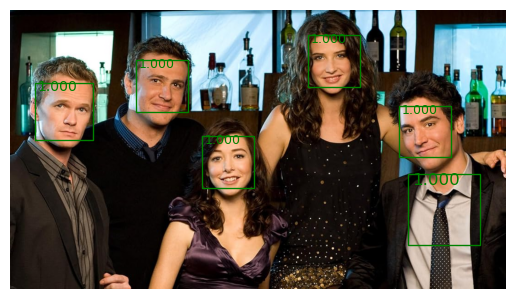

In [77]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "how_i_met_your_mother.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

In the above image, a false positive detection of a face can be observed, even marked with the maximum score.

# Face Detection Settings Info #

Generated 40833 windows:
- maximum size: 645x645
- minimum size: 97x97
- scaling ratio: 0.9

Detected 87 faces during sliding windows classification
Kept 19 faces with a probability over 97.5%
Kept 3 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 3 faces inside the image for at least 75% of their area

Face detection completed in 1771.28 seconds



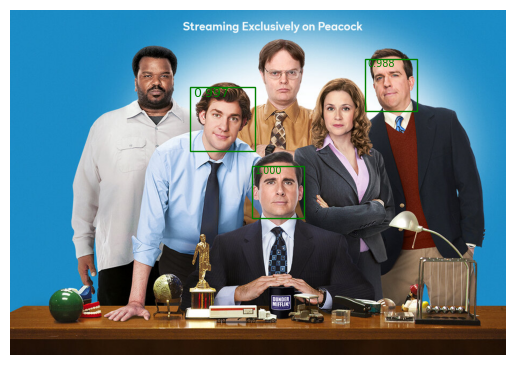

In [78]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "the_office.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

In the image above, it can be observed that not all faces have been detected, despite being of similar sizes and possessing similar characteristics to those that were detected.

# Face Detection Settings Info #

Generated 29798 windows:
- maximum size: 781x781
- minimum size: 161x161
- scaling ratio: 0.9

Detected 173 faces during sliding windows classification
Kept 10 faces with a probability over 97.5%
Kept 3 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 1 faces inside the image for at least 75% of their area

Face detection completed in 1305.04 seconds



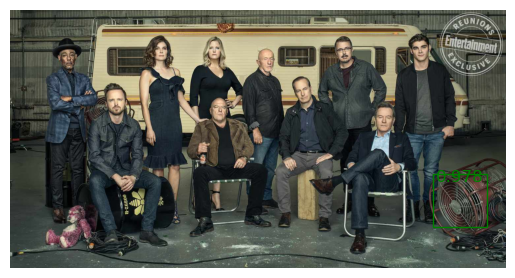

In [79]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "breaking_bad.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

When faces are relatively small compared to the size of the image and thus the window, the model fails to detect the faces.

# Face Detection Settings Info #

Generated 35274 windows:
- maximum size: 352x352
- minimum size: 65x65
- scaling ratio: 0.9

Detected 321 faces during sliding windows classification
Kept 48 faces with a probability over 97.5%
Kept 4 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 2 faces inside the image for at least 75% of their area

Face detection completed in 1529.79 seconds



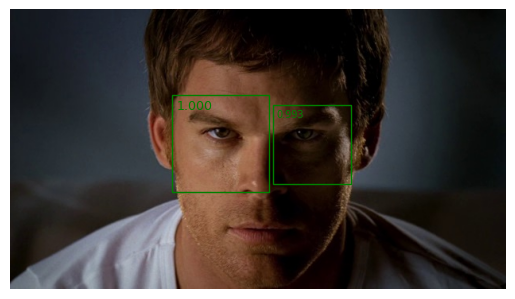

In [80]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "dexter.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

Also large faces sometimes exhibit poor detection result.

#### Further Detection Tests - Other Images

# Face Detection Settings Info #

Generated 43332 windows:
- maximum size: 735x735
- minimum size: 110x110
- scaling ratio: 0.9

Detected 95 faces during sliding windows classification
Kept 0 faces with a probability over 97.5%
Kept 0 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 0 faces inside the image for at least 75% of their area

Face detection completed in 1890.30 seconds



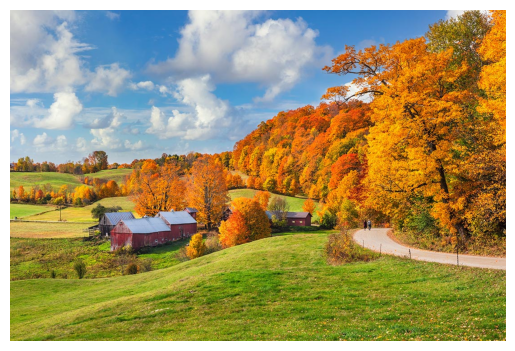

In [81]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "landscape.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

Good result for the above natural image.

# Face Detection Settings Info #

Generated 22360 windows:
- maximum size: 546x546
- minimum size: 155x155
- scaling ratio: 0.9

Detected 71 faces during sliding windows classification
Kept 3 faces with a probability over 97.5%
Kept 2 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 0 faces inside the image for at least 75% of their area

Face detection completed in 974.53 seconds



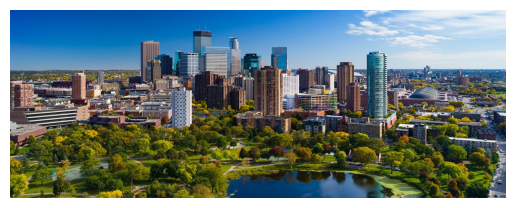

In [82]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "city.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

Good result for the above urban image.

# Face Detection Settings Info #

Generated 42798 windows:
- maximum size: 3999x3999
- minimum size: 601x601
- scaling ratio: 0.9

Detected 109 faces during sliding windows classification
Kept 0 faces with a probability over 97.5%
Kept 0 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 0 faces inside the image for at least 75% of their area

Face detection completed in 2233.55 seconds



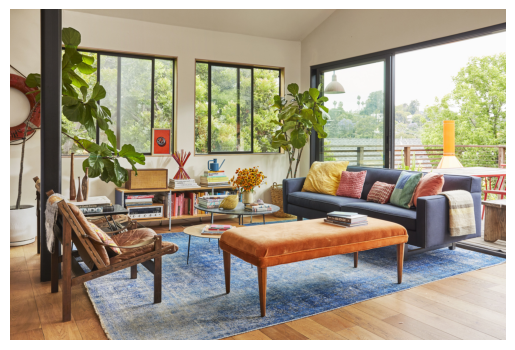

In [83]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "living_room.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

Good result for the above living room image.

# Face Detection Settings Info #

Generated 52576 windows:
- maximum size: 800x800
- minimum size: 87x87
- scaling ratio: 0.9

Detected 639 faces during sliding windows classification
Kept 109 faces with a probability over 97.5%
Kept 15 faces after non-maximum-suppression with overlap threshold of 0.1 
Kept 13 faces inside the image for at least 75% of their area

Face detection completed in 2282.76 seconds



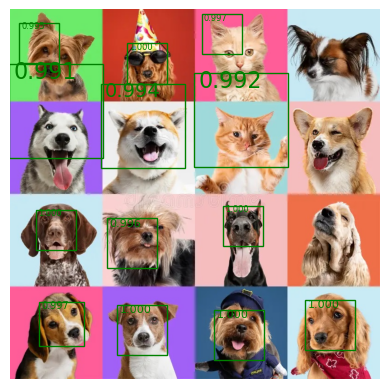

In [84]:
# Image path
image_path = os.path.join(TEST_DATA_FOLDER, "animals.jpg")

# Load model pipeline and settings paths
model_path = os.path.join(MODELS_FOLDER, "pipe_svc.pkl")
json_path = os.path.join(MODELS_FOLDER, "global_settings.json")

# Return faces detected list
faces_detected_boxes = faces_detector(image_path, model_path, json_path)

Animal faces seem to mislead the model to detect human faces.

## Conclusions

The face detection model demonstrates decent results, however with room for improvements. Additional training images, specifically curated to enhance the extraction of facial features, could enhance the model performance furtherly. In the same way providing animal faces for negative classes could reduce false positive for non-human faces exhibiting similar characteristics. <br>
Moreover, optimization of the window generation process by adjusting dimensions and positions could help mitigate the excessively long detection times associated with exhaustive window sliding.